In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from PIL import Image
from glob import glob

import os
import shutil

In [2]:
class IntelDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
class IntelClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(IntelClassifier, self).__init__()

        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../data/seg_train'
test_folder = '../data/seg_test'

train_dataset = IntelDataset(train_folder, transform=transform)
test_dataset = IntelDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
num_epochs = 6
train_losses = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = IntelClassifier(num_classes=6)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(num_epochs):

    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}")

Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1/6 - Train loss: 0.3878767039933163


Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/6 - Train loss: 0.23719932892153672


Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/6 - Train loss: 0.20190100845608325


Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/6 - Train loss: 0.1560624462511357


Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/6 - Train loss: 0.14184871157324686


Training loop:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 6/6 - Train loss: 0.11325719086321923


In [16]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualiz_predictions(original_image, probabilities, class_names, i):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.savefig(f"../results/plots/{i}.jpg", format='jpg', dpi=300)
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Predicting"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [12]:
evaluate_model(model, test_loader, device)

Predicting:   0%|          | 0/94 [00:00<?, ?it/s]

Test Accuracy: 89.97%


0.8996666666666666

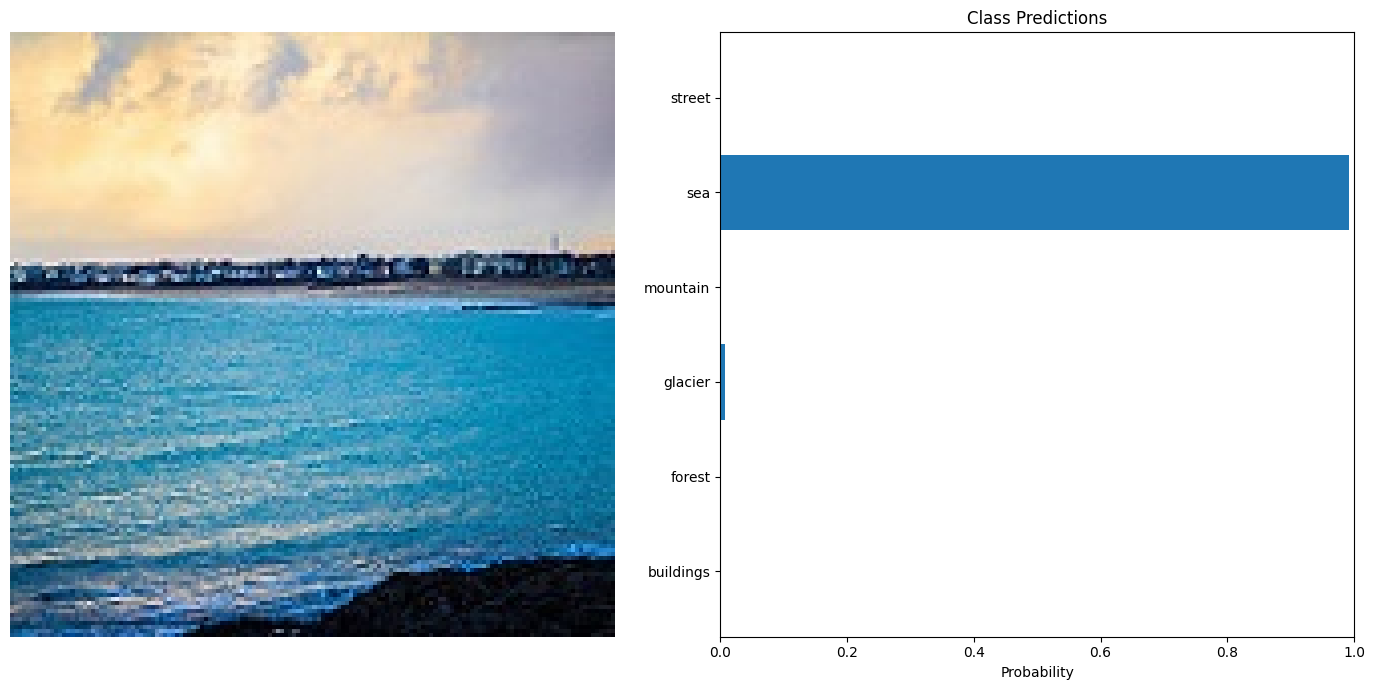

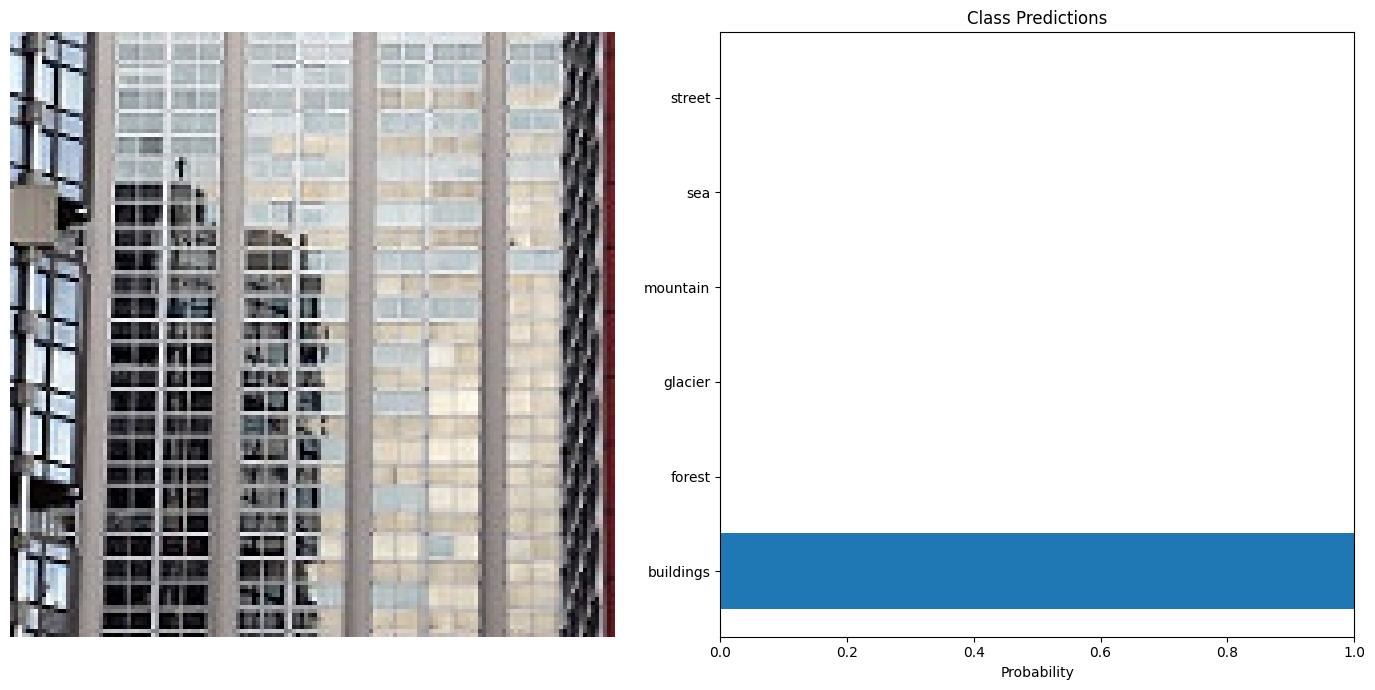

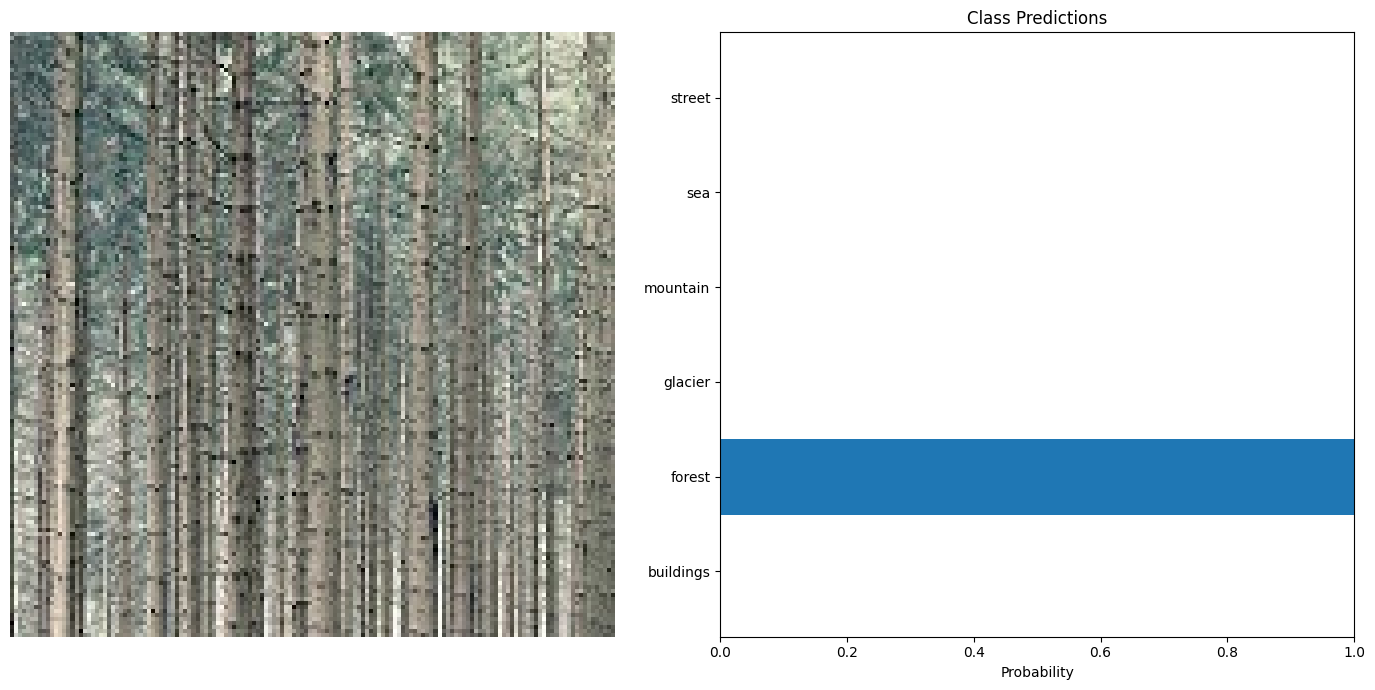

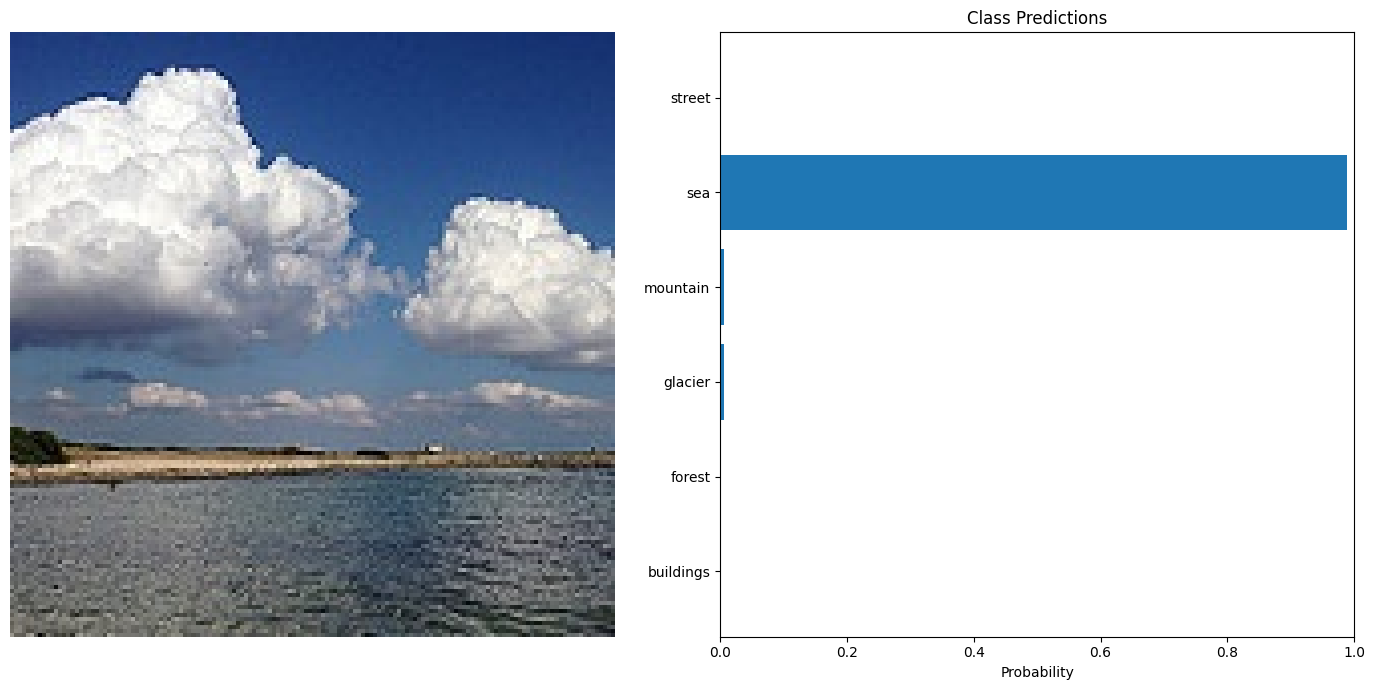

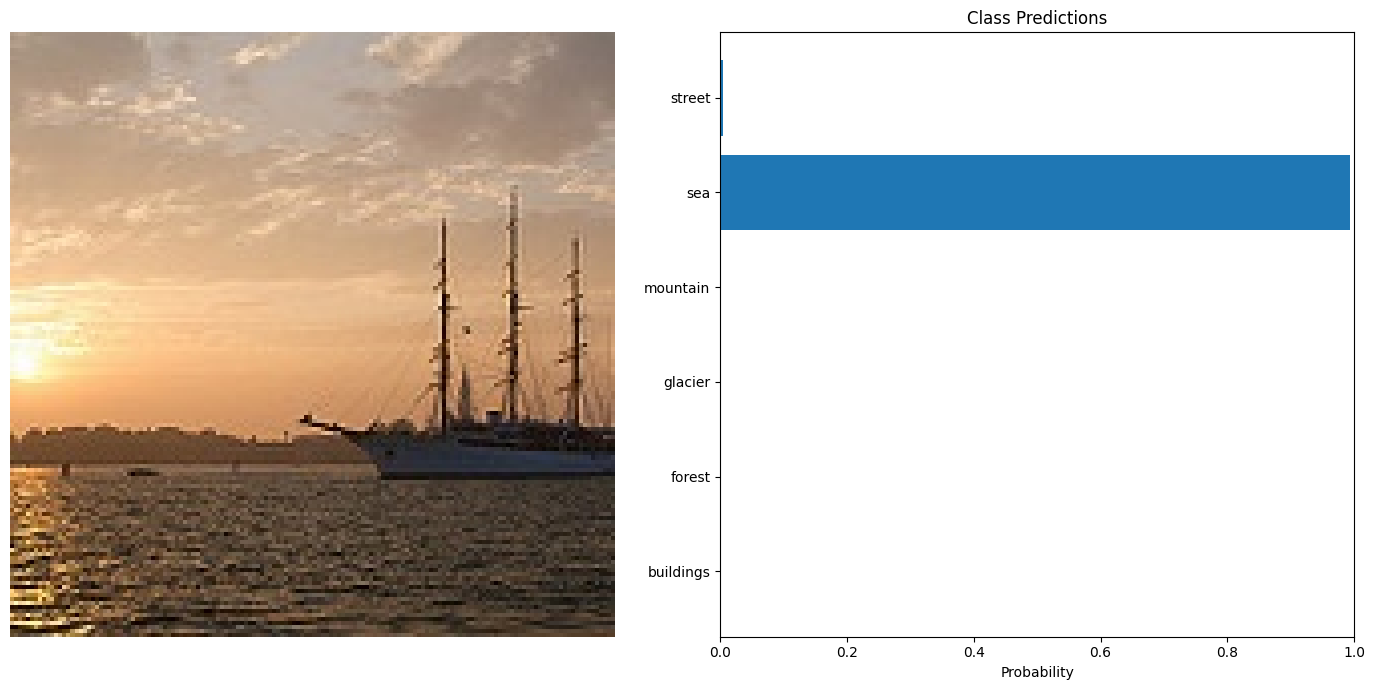

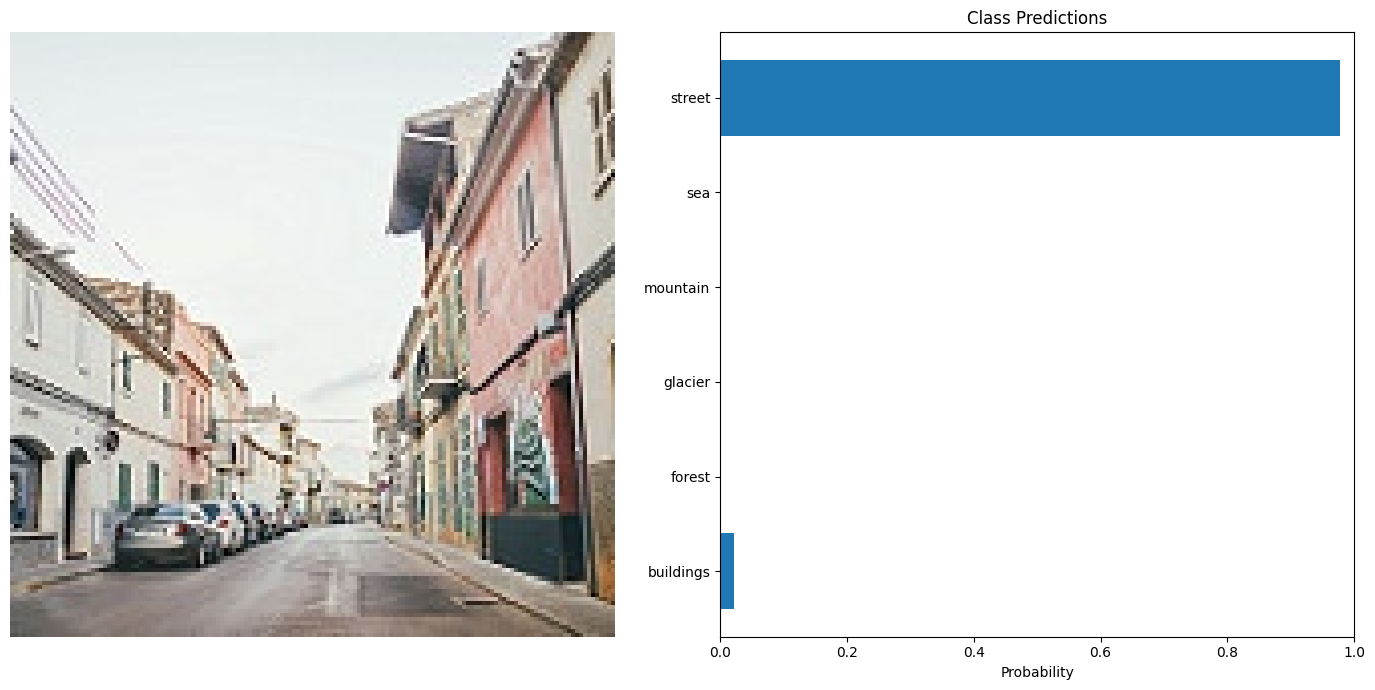

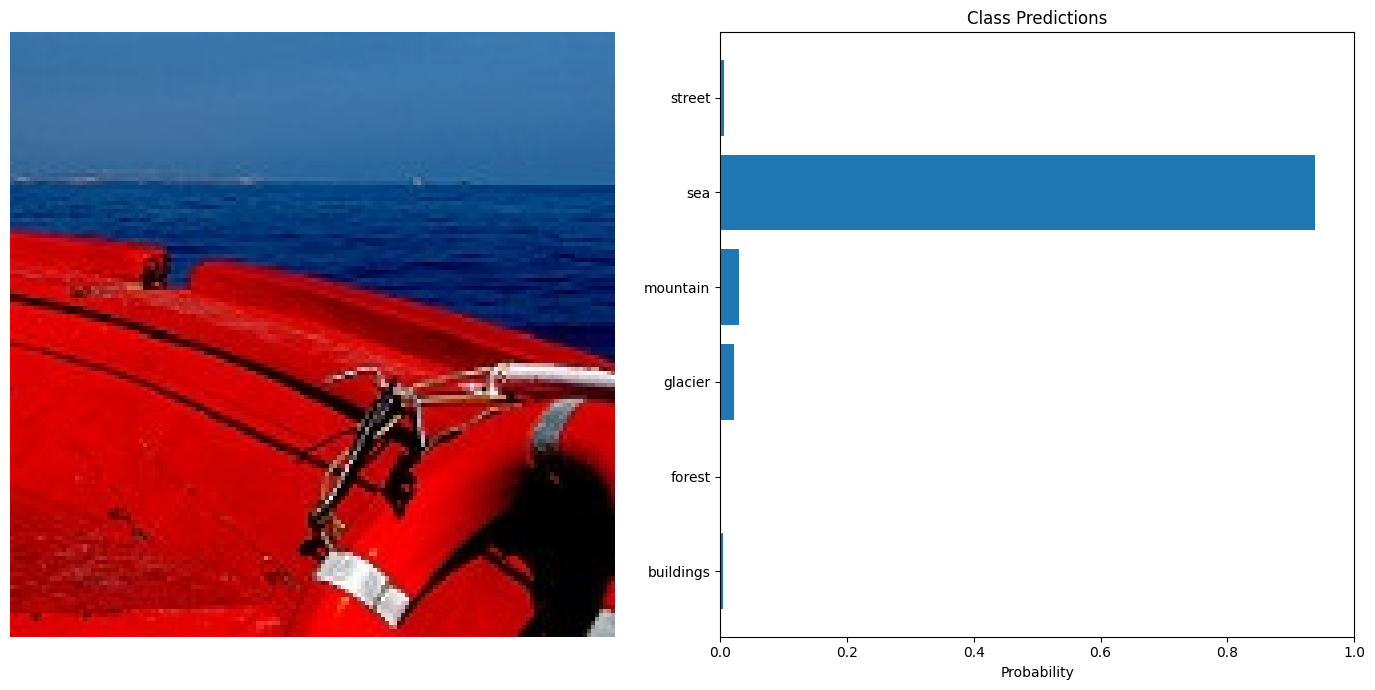

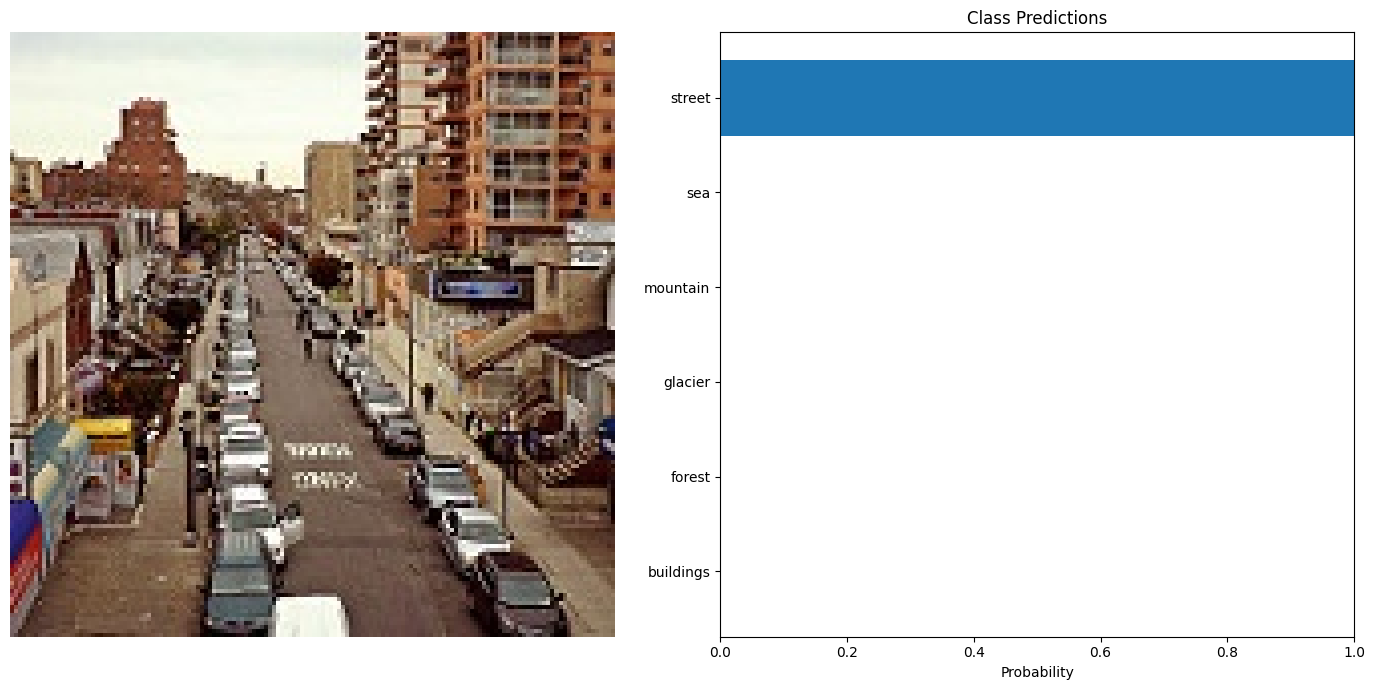

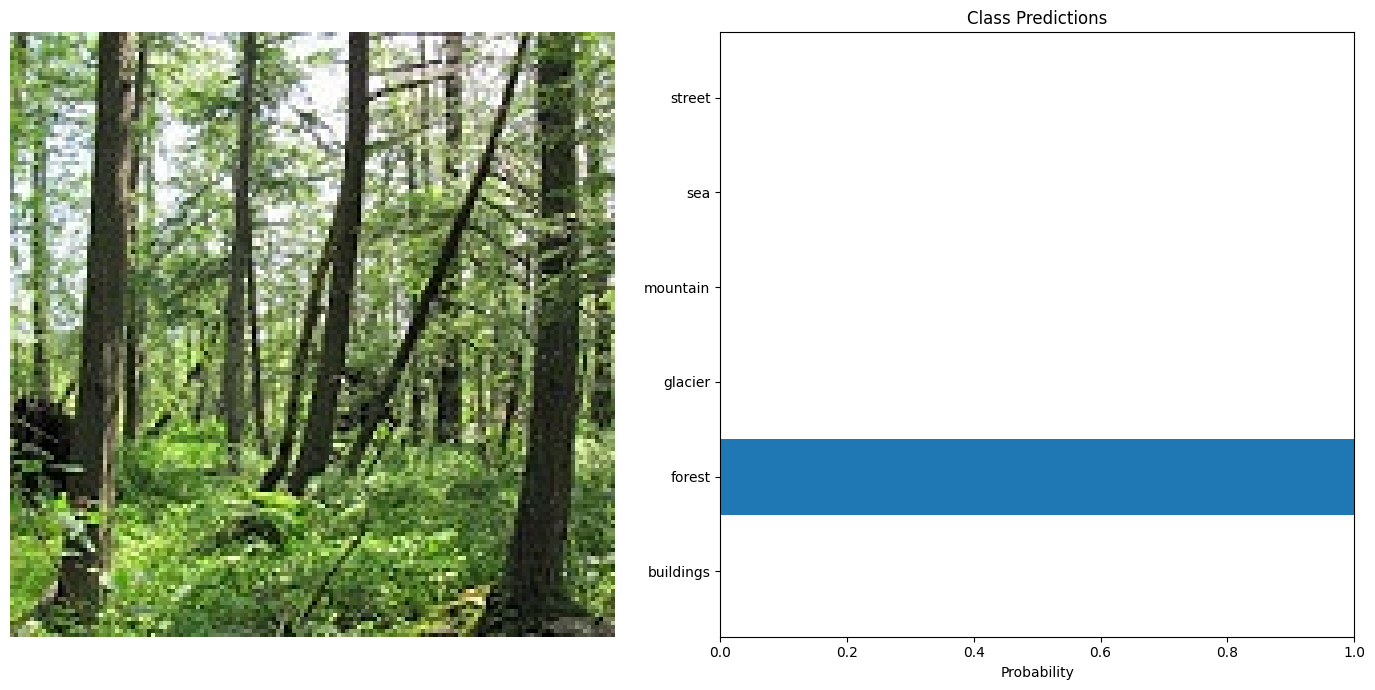

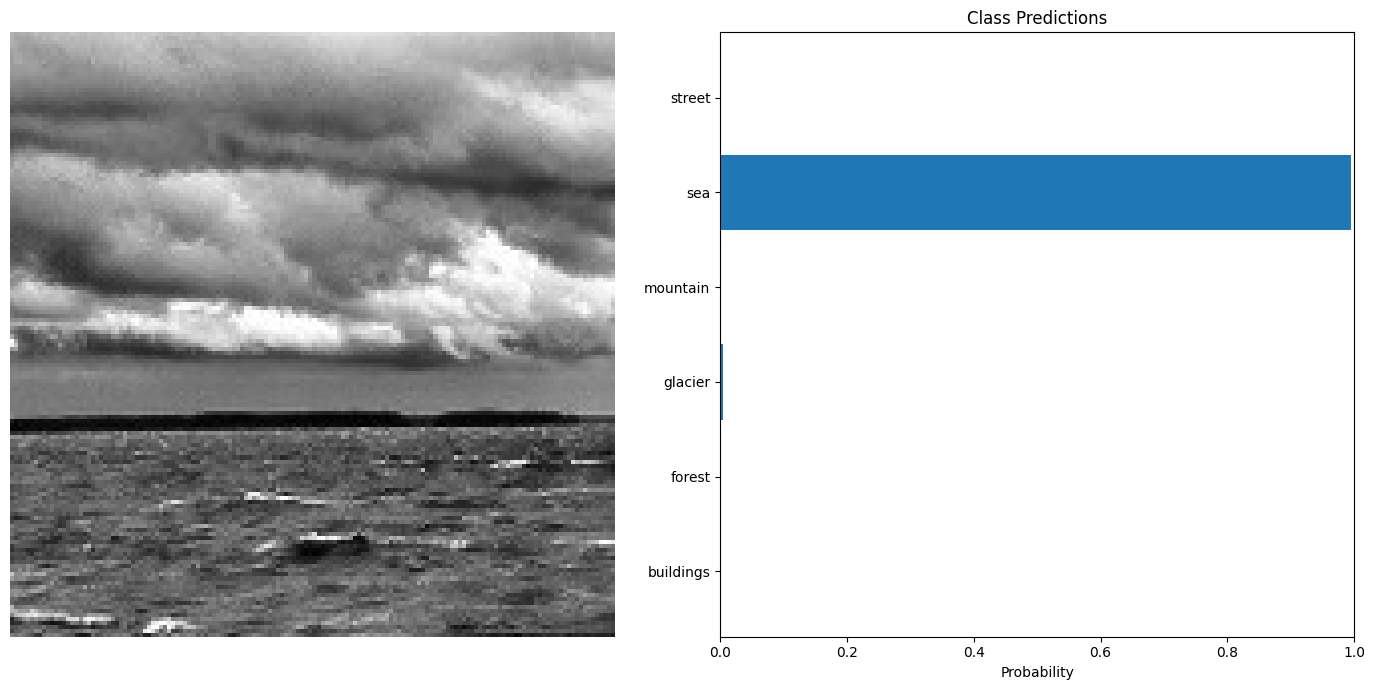

In [17]:
test_images = glob('../data/seg_test/*/*')
test_examples = np.random.choice(test_images, 10)
class_names = test_dataset.classes

i = 1

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    visualiz_predictions(original_image, probabilities, class_names, i)
    i += 1

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert('RGB')
        return self.transform(image), path

pred_images = glob('../data/seg_pred/*')
batch_size = 64

dataset = PredictionDataset(pred_images, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

path = '../results/predicted_img'
for class_name in class_names:
    os.makedirs(os.path.join(path, class_name), exist_ok=True)

model.eval()
with torch.no_grad():
    for images, paths in tqdm(loader):
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted_classes = probs.argmax(dim=1).cpu().numpy()

        for img_path, class_idx in zip(paths, predicted_classes):
            class_name = class_names[class_idx]
            shutil.copy(img_path, os.path.join(path, class_name))